In [2]:
import torch as tc
import torch.nn as nn

In [1]:
import math

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, features: int, heads: int):
        super().__init__()
        self.heads = heads
        self.projectionDim = features // heads

        self.W_q = nn.Linear(features, features)
        self.W_k = nn.Linear(features, features)
        self.W_v = nn.Linear(features, features)
        self.W_o = nn.Linear(features, features)

    def forward(self, x: tc.Tensor) -> tc.Tensor:
        batch, tokens, features = x.shape

        Q = self.W_q(x).reshape(batch, tokens, self.heads, self.projectionDim).transpose(1, 2)
        K = self.W_k(x).reshape(batch, tokens, self.heads, self.projectionDim).transpose(1, 2)
        V = self.W_v(x).reshape(batch, tokens, self.heads, self.projectionDim).transpose(1, 2)
        # Q, K, V now (batch, heads, tokens, projectionDim)

        scores = tc.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.projectionDim)
        weights = tc.softmax(scores, dim=-1)        # (batch, heads, tokens, tokens)

        output = tc.matmul(weights, V)              # (batch, heads, tokens, projectionDim)
        output = output.transpose(1, 2).reshape(batch, tokens, features)  # concatenate heads
        return self.W_o(output)

In [11]:
class Transformer(nn.Module):
    def __init__(self, features: int, heads: int):
        super().__init__()

        self.MHSA = MultiHeadSelfAttention(features, heads)

        self.MLP = nn.Sequential(
            nn.Linear(features, 4 * features),  # expand
            nn.GELU(),                          # nonlinearity
            nn.Linear(4 * features, features),  # contract back
        )

        self.norm1 = nn.LayerNorm(features)
        self.norm2 = nn.LayerNorm(features)

    def forward(self, x: tc.Tensor) -> tc.Tensor:
        x_bar = self.norm1(x)
        y = x + self.MHSA(x_bar)
        y_bar = self.norm2(y)
        return y + self.MLP(y_bar)

In [43]:
def sinusoidal_encoding(N, d_model):
    pos_encode = tc.zeros(N, d_model)
    position = tc.arange(0, N).unsqueeze(1).float()  # (N, 1)
    div_term = tc.exp(tc.arange(0, d_model, 2).float() *
                         (-math.log(10000.0) / d_model))
    pos_encode[:, 0::2] = tc.sin(position * div_term)
    pos_encode[:, 1::2] = tc.cos(position * div_term)
    return pos_encode  # (N, d_model)


class HeatTransformer(nn.Module):
    def __init__(self, features: int, heads: int, num_layers: int, grid_size: int):
        super().__init__()
        self.input_proj = nn.Linear(1,features)
        self.pos_encoding = sinusoidal_encoding(grid_size, features)
        self.transformer_blocks = nn.ModuleList([Transformer(features, heads) for _ in range(num_layers)])
        self.output_proj = nn.Linear(features, 1)

        #self.register_buffer('pos_encoding', sinusoidal_encoding(grid_size, features))

    def forward(self, x: tc.Tensor) -> tc.Tensor:
        x = self.input_proj(x)
        x = x + self.pos_encoding
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.output_proj(x)
        return x.squeeze(-1)


In [61]:
import numpy as np

def random_initial_condition(x, n_modes=5):
    u0 = np.zeros_like(x)
    amps = []
    for k in range(1, n_modes + 1):
        amplitude = np.random.uniform(-1, 1)
        u0 += amplitude * np.sin(k * np.pi * x)
        amps.append(amplitude)
    return u0, amps

In [9]:
from scipy.integrate import solve_ivp

def solve_heat_equation(u0, x, t_end=0.1, alpha=1.0):
    N = len(x)
    dx = x[1] - x[0]

    def heat_rhs(t, u):
        dudt = np.zeros_like(u)
        # finite difference for second derivative
        dudt[1:-1] = alpha * (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2
        # boundary conditions: u[0] = u[-1] = 0 (already zero)
        return dudt

    sol = solve_ivp(heat_rhs, [0, t_end], u0, method='RK45',
                    t_eval=[t_end], rtol=1e-6, atol=1e-8)
    return sol.y[:, -1]  # solution at t_end

In [10]:
N = 64          # spatial grid points
x = np.linspace(0, 1, N)
n_samples = 10000

inputs = []
targets = []

for _ in range(n_samples):
    u0, _ = random_initial_condition(x)
    uT = solve_heat_equation(u0, x)
    inputs.append(u0)
    targets.append(uT)

inputs = np.array(inputs)   # (10000, 64)
targets = np.array(targets) # (10000, 64)
np.save('inputs.npy', inputs)
np.save('targets.npy', targets)

In [13]:
from torch.utils.data import TensorDataset, DataLoader
# Don't need to load if calculating data for the first time
# inputs = np.load('inputs.npy')
# targets = np.load('targets.npy')
X = tc.tensor(inputs, dtype=tc.float32).unsqueeze(-1)  # (10000, 64, 1)
Y = tc.tensor(targets, dtype=tc.float32)               # (10000, 64)

dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = tc.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

In [46]:
model = HeatTransformer(features=64, heads=4, num_layers=3, grid_size=64)
optimizer = tc.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=5, factor=0.5
)

for epoch in range(100):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with tc.no_grad():
        for x_batch, y_batch in val_loader:
            pred = model(x_batch)
            val_loss += loss_fn(pred, y_batch).item()

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")
    scheduler.step(val_loss)

Epoch 1 | Train Loss: 0.018314 | Val Loss: 0.004520
Epoch 2 | Train Loss: 0.003222 | Val Loss: 0.002161
Epoch 3 | Train Loss: 0.001456 | Val Loss: 0.001027
Epoch 4 | Train Loss: 0.000809 | Val Loss: 0.000653
Epoch 5 | Train Loss: 0.000549 | Val Loss: 0.000466
Epoch 6 | Train Loss: 0.000403 | Val Loss: 0.000355
Epoch 7 | Train Loss: 0.000306 | Val Loss: 0.000274
Epoch 8 | Train Loss: 0.000241 | Val Loss: 0.000214
Epoch 9 | Train Loss: 0.000193 | Val Loss: 0.000181
Epoch 10 | Train Loss: 0.000158 | Val Loss: 0.000143
Epoch 11 | Train Loss: 0.000135 | Val Loss: 0.000120
Epoch 12 | Train Loss: 0.000119 | Val Loss: 0.000104
Epoch 13 | Train Loss: 0.000105 | Val Loss: 0.000093
Epoch 14 | Train Loss: 0.000090 | Val Loss: 0.000081
Epoch 15 | Train Loss: 0.000081 | Val Loss: 0.000079
Epoch 16 | Train Loss: 0.000074 | Val Loss: 0.000064
Epoch 17 | Train Loss: 0.000067 | Val Loss: 0.000062
Epoch 18 | Train Loss: 0.000062 | Val Loss: 0.000056
Epoch 19 | Train Loss: 0.000069 | Val Loss: 0.000048
Ep

In [16]:
def analytical_solution(u0_amplitudes, x, t, alpha=1.0):
    u = np.zeros_like(x)
    for k, A in enumerate(u0_amplitudes, start=1):
        u += A * np.sin(k * np.pi * x) * np.exp(-alpha * (k * np.pi)**2 * t)
    return u

In [62]:
import time

n_test = 100

test_inputs = []
test_amplitudes = []
for _ in range(n_test):
    u0, a = random_initial_condition(x)
    test_inputs.append(u0)
    test_amplitudes.append(a)

test_tensor = tc.tensor(np.array(test_inputs), dtype=tc.float32).unsqueeze(-1)

In [22]:
test_tensor.shape

torch.Size([1000, 64, 1])

In [47]:
# scipy
start = time.time()
for u0 in test_inputs:
    solve_heat_equation(u0, x)
scipy_time = time.time() - start

# transformer
start = time.time()
with tc.no_grad():
    model(test_tensor)
transformer_time = time.time() - start

print(f"Scipy: {scipy_time:.3f}s | Transformer: {transformer_time:.3f}s | Speedup: {scipy_time/transformer_time:.1f}x")

Scipy: 1.971s | Transformer: 0.015s | Speedup: 134.6x


In [64]:
sp_solution = solve_heat_equation(test_inputs[0], x)

In [75]:
ht_solution = model(test_tensor).detach().numpy()

In [76]:
ana_solution = np.zeros_like(ht_solution)
for i in range(100):
    ana_solution[i,:] = analytical_solution(test_amplitudes[i], x, t = 0.1)

In [58]:
np.max(np.abs(ana_solution))

np.float64(3.477846324179675e-05)

In [59]:
np.max(np.abs(sp_solution))

np.float64(0.2909036334702826)

In [29]:
import matplotlib.pyplot as plt

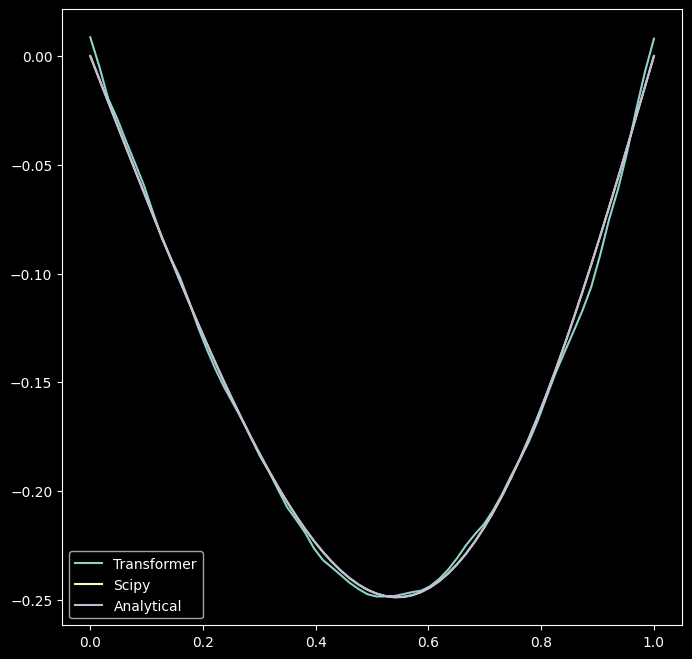

In [68]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x, ht_solution, label='Transformer')
ax.plot(x, sp_solution, label='Scipy')
ax.plot(x, ana_solution, label='Analytical')
ax.legend()
plt.show()

In [70]:
np.sum(np.power(ht_solution - sp_solution, 2))

np.float64(0.0007863956385959595)

In [71]:
np.sum(np.power(ana_solution - sp_solution, 2))

np.float64(1.8550368221530188e-07)

In [72]:
np.sum(np.power(ht_solution - ana_solution, 2))

np.float64(0.0007898604759843302)

In [77]:
relative_l2 = 0
for i in range(100):
    relative_l2 += np.sqrt(np.sum((ht_solution[i,:] - ana_solution[i,:])**2)) / np.sqrt(np.sum(ana_solution**2)) / 100

In [78]:
print(relative_l2)

0.0012570436
